In [70]:
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import streamlit as st
import os
from langchain_mcp_adapters.tools import load_mcp_tools
from IPython.display import Markdown, display
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, Markdown, display


In [72]:
from typing import Dict,Annotated,List
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.messages import SystemMessage, HumanMessage


class ArticleResponse(TypedDict):
    topic: str
    summary: str
    knowledge: Annotated[list[AnyMessage], add_messages]
    
   

In [73]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [74]:
model_name = "moonshotai/kimi-k2-instruct" #"moonshotai/kimi-k2-instruct" "qwen/qwen3-32b"
temperature = 0.0


llm = ChatGroq(
    model_name=model_name,
    temperature=temperature
)   


In [75]:
async def airbnbAgent(state):
    
    server_params = StdioServerParameters(
            command= "npx",
            args= [
                "-y",
                "@openbnb/mcp-server-airbnb",
                "--ignore-robots-txt"
            ],
        )
    
    
    async with stdio_client(server_params) as (read, write):
            async with ClientSession(read, write) as session:
                print("Initializing connection...")
                await session.initialize()

                # Get tools
                print("Loading tools...")
                tools = await load_mcp_tools(session)
                
                
                agent = create_react_agent(
                    model=llm,
                    tools=tools,
                    prompt = (
                        """
                        **ADVANCED HOTEL SEARCH FORMAT**

                        ## 🎯 Search Summary
                        - **Location:** [location] | **Dates:** [checkin] → [checkout]
                        - **Guests:** [adults]A, [children]C, [infants]I, [pets]P
                        - **Room:** [room type] | **Stars:** [rating] | **Amenities:** [amenities]
                        - **Results:** [number] hotels

                        ## 🏨 Hotel Listings
                        ### [Hotel Name]
                        | Detail | Info |
                        |--------|------|
                        | ⭐ Rating | [rating]/5 ([reviews]) |
                        | 📍 Address | [full address] |
                        | 💰 Rate | $[price]/night (+$[tax]) |
                        | 🏠 Rooms | [categories] |
                        | 📏 Distance | [city center] • [airport] |
                        | 🔗 Booking | [URL] |
                        | 📞 Contact | [phone] • [website] |

                        **Amenities:** [pool/gym/spa, dining, transport, business, pets, WiFi, services]  
                        **Booking:** Check-in [time], Check-out [time], Cancellation [policy], Payment [methods], Breakfast [info], Parking [info], Extra Beds [policy]

                        **Match Analysis:** Budget [fit], Amenities [X/Y matched], Location [score], Guest Reviews [highlights]  
                        **Recommendations:** Best for [use case], Offers [promos], Tips [advice]

                        -- repeat per hotel --

                        ## 📈 Comparison
                        | Hotel | Rating | Price | Features | Link |
                        |-------|--------|-------|----------|------|
                        | [H1] | [rating]⭐ | $[price] | [2 highlights] | [URL] |
                        | [H2] | [rating]⭐ | $[price] | [2 highlights] | [URL] |

                        ## 🏆 Final Picks
                        - **Best Value:** [hotel + reason]
                        - **Luxury:** [hotel + features]
                        - **Budget:** [hotel + savings]
                        - **Location:** [hotel + benefit]
                        - **Amenities:** [hotel + standout]
                        """
                    )
                )
            
                response = await agent.ainvoke({"messages": [{"role": "user", "content": state['topic']}]})

                ai_content = response["messages"][-1].content

                return {"knowledge": [f"[Info from AirBnb Search]\n{ai_content}\n\n"]}
                

In [78]:
res = await airbnbAgent({"topic": "Find me the top 5 Airbnb in Darjeeling for next 3 days within 8000 for 2 people?"})

Initializing connection...
Loading tools...


In [79]:
display(Markdown(f"# 📝 Report\n\n{res['knowledge']}"))

# 📝 Report

["[Info from AirBnb Search]\nBased on my search, I found several excellent Airbnb options in Darjeeling within your budget of ₹8000 for 2 people. Here are the **Top 5 Airbnb listings** that offer great value, location, and guest satisfaction:\n\n## 🏆 Top 5 Airbnb in Darjeeling (Within ₹8000 for 2 People)\n\n### 1. **Charming A-Frame Retreat** ⭐ 4.86/5 (21 reviews)\n- **Price:** ₹5,706 for 5 nights (₹1,141/night)\n- **Beds:** 1 bed\n- **Status:** Guest favourite\n- **Link:** https://www.airbnb.com/rooms/1133233227086652662\n- **Best for:** Couples seeking a cozy, unique stay with excellent ratings\n\n### 2. **Teesta Homestay (Traveler's Room)** ⭐ 4.87/5 (137 reviews)\n- **Price:** ₹5,136 for 5 nights (₹1,027/night)\n- **Status:** Guest favourite\n- **Link:** https://www.airbnb.com/rooms/17026446\n- **Best for:** Budget-conscious travelers with excellent reviews\n\n### 3. **A Quiet Nest-Green room: view of Kangchenjunga** ⭐ 4.87/5 (119 reviews)\n- **Price:** ₹5,718 for 5 nights (₹1,143/night)\n- **Status:** Guest favourite\n- **Link:** https://www.airbnb.com/rooms/52215996\n- **Best for:** Mountain views and peaceful atmosphere\n\n### 4. **Feel At Home (Entire Apartment)** ⭐ 4.82/5 (332 reviews)\n- **Price:** ₹6,277 for 5 nights (₹1,255/night)\n- **Beds:** 2 double beds\n- **Status:** Guest favourite\n- **Link:** https://www.airbnb.com/rooms/9403847\n- **Best for:** Groups/families wanting entire apartment space\n\n### 5. **Feel at home 2.0 (Entire Apartment)** ⭐ 4.69/5 (119 reviews)\n- **Price:** ₹5,763 for 5 nights (₹1,152/night)\n- **Beds:** 3 beds\n- **Link:** https://www.airbnb.com/rooms/650396672271384685\n- **Best for:** Larger groups needing multiple beds\n\n## 📊 Quick Comparison\n| Property | Rating | Price/Night | Type | Best Feature |\n|----------|--------|-------------|------|--------------|\n| A-Frame Retreat | 4.86⭐ | ₹1,141 | 1 bed | Unique architecture |\n| Teesta Homestay | 4.87⭐ | ₹1,027 | Traveler's room | Lowest price |\n| Quiet Nest | 4.87⭐ | ₹1,143 | Green room | Kangchenjunga views |\n| Feel At Home | 4.82⭐ | ₹1,255 | Entire apartment | 332 reviews |\n| Feel at Home 2.0 | 4.69⭐ | ₹1,152 | 3-bed apartment | Spacious |\n\n## 🎯 My Recommendations:\n- **Best Value:** **Teesta Homestay** - Lowest price with highest guest satisfaction\n- **Best for Couples:** **A-Frame Retreat** - Unique, cozy, and highly rated\n- **Best Views:** **Quiet Nest** - Kangchenjunga mountain views\n- **Best Space:** **Feel At Home** - Entire apartment with multiple beds\n\nAll these properties are well within your ₹8000 budget for 3 days and offer excellent guest experiences based on their ratings and reviews. Would you like me to get more detailed information about any specific property?\n\n"]

In [80]:
import requests
import json
import os

In [81]:
def extract_weather(data: dict) -> str:
    """
    Extracts location, current weather, and 3-day forecast info from WeatherAPI JSON.
    Returns as a formatted string instead of printing.
    """
    lines = []

    # --- Location info ---
    loc = data.get("location", {})
    location = f"{loc.get('name')}, {loc.get('region')}, {loc.get('country')}"
    lines.append(f"📍 Location: {location}")

    # --- Current weather ---
    current = data.get("current", {})
    condition = current.get("condition", {}).get("text")
    temp_c = current.get("temp_c")
    feelslike_c = current.get("feelslike_c")
    humidity = current.get("humidity")
    gust_kph = current.get("gust_kph")
    pressure_mb = current.get("pressure_mb")

    lines.append("\n🌤️ Current Weather:")
    lines.append(f"  Temp: {temp_c}°C (Feels like {feelslike_c}°C)")
    lines.append(f"  Condition: {condition}")
    lines.append(f"  Humidity: {humidity}%")
    lines.append(f"  Wind Gust: {gust_kph} kph")
    lines.append(f"  Pressure: {pressure_mb} mb")

    # --- Forecast info ---
    forecast = data.get("forecast", {}).get("forecastday", [])
    lines.append("\n📅 Forecast:")
    for day in forecast:
        d = day.get("date")
        details = day.get("day", {})
        lines.append(f"  Date: {d}")
        lines.append(f"    Condition: {details.get('condition', {}).get('text')}")
        lines.append(f"    Max Temp: {details.get('maxtemp_c')}°C")
        lines.append(f"    Min Temp: {details.get('mintemp_c')}°C")
        lines.append(f"    Avg Humidity: {details.get('avghumidity')}%")
        lines.append(f"    Max Wind: {details.get('maxwind_kph')} kph")
        lines.append("-" * 40)

    return "\n".join(lines)


In [82]:
@tool("WeatherForecast")
def get_forecast(location: str, days: int = 3):
    """
    Fetch weather forecast for a given location using WeatherAPI.

    Args:
        location (str): City name or coordinates (e.g., "London" or "51.5072,-0.1276").
        days (int): Number of days to forecast (default = 3).

    Returns:
        dict: Forecast data if successful, None otherwise.
    """
    print("WeatherForecast tool")
    API_KEY = os.getenv("WEATHER_API_KEY")  # ⚠️ keep private in real apps
    
    params = {
        "key": API_KEY,
        "q": location,
        "days": days,
        "aqi": "no",
        "alerts": "yes"
    }

    BASE_URL = f"http://api.weatherapi.com/v1/forecast.json?key={params['key']}&q={params['q']}&days={params['days']}&aqi={params['aqi']}&alerts={params['alerts']}"

    try:
        response = requests.get(BASE_URL, timeout=10)
        response.raise_for_status()  # raise error for bad status
        data = response.json()
        forecast = extract_weather(data)
        return forecast
    except requests.RequestException as e:
        print(f"Error fetching forecast: {e}")
        return None

In [83]:
weather = get_forecast.invoke("Darjeeling")

WeatherForecast tool


In [51]:
print(weather)

📍 Location: Darjeeling, West Bengal, India

🌤️ Current Weather:
  Temp: 19.5°C (Feels like 19.5°C)
  Condition: Patchy rain nearby
  Humidity: 93%
  Wind Gust: 8.0 kph
  Pressure: 1011.0 mb

📅 Forecast:
  Date: 2025-09-06
    Condition: Moderate rain
    Max Temp: 21.7°C
    Min Temp: 16.4°C
    Avg Humidity: 89%
    Max Wind: 8.3 kph
----------------------------------------
  Date: 2025-09-07
    Condition: Moderate rain
    Max Temp: 20.9°C
    Min Temp: 17.7°C
    Avg Humidity: 89%
    Max Wind: 7.2 kph
----------------------------------------
  Date: 2025-09-08
    Condition: Moderate rain
    Max Temp: 21.6°C
    Min Temp: 16.3°C
    Avg Humidity: 92%
    Max Wind: 5.4 kph
----------------------------------------


In [97]:
def weatherAgent(state):
    print("Weather Agent..")
    weather_agent = create_react_agent(
            model=llm,
            tools=[get_forecast],
            prompt = (
                """
                You are a Weather Assistant.

                - Use the **WeatherForecast tool** to fetch the forecast for the location mentioned in the query.  
                - Then generate a **Weather Report** strictly following the Markdown format below.  
                - Do not add extra sections, explanations, or text outside the format.  
                - Fill in <placeholders> with actual values.  

                ## Weather Report for <Location> (Next <Days> Days)

                **Current Conditions:** <CurrentTemp>°C with <CurrentCondition> (<Rain/Heatwave/Clear/Other summary>)

                **Forecast Summary:**
                - **<Date 1>:** <Condition>, <MaxTemp>°C / <MinTemp>°C (<Rain/Heatwave/Clear/Other summary>)
                - **<Date 2>:** <Condition>, <MaxTemp>°C / <MinTemp>°C (<Rain/Heatwave/Clear/Other summary>)
                - **<Date 3>:** <Condition>, <MaxTemp>°C / <MinTemp>°C (<Rain/Heatwave/Clear/Other summary>)
                ... (repeat for all forecast days)

                **Tour Recommendation:**  
                Based on the weather forecast, state clearly if it is a good time to visit <Location>. 
                Give practical advice: clothing, precautions, indoor/outdoor activity suggestions.
                """
            ),
            name="Weather Forecast Assistant",
        )

    result = weather_agent.invoke({"messages": [{"role": "user", "content": state['topic']}]})
    ai_content = result["messages"][-1].content

    return {"knowledge": [f"[Info from Weather Search]\n{ai_content}\n\n"]}

In [98]:
result = weatherAgent({'topic': 'Find me the top 5 Airbnb in Darjeeling for next 3 days within 8000 for 2 people ?'})

Weather Agent..
WeatherForecast tool


In [99]:
print(result)

{'knowledge': ['[Info from Weather Search]\n## Weather Report for Darjeeling (Next 3 Days)\n\n**Current Conditions:** 19.1°C with Patchy rain nearby (Rain)\n\n**Forecast Summary:**\n- **2025-09-07:** Moderate rain, 20.9°C / 17.7°C (Rain)\n- **2025-09-08:** Moderate rain, 21.6°C / 16.3°C (Rain)\n- **2025-09-09:** Moderate rain, 21.5°C / 16.8°C (Rain)\n\n**Tour Recommendation:**  \nBased on the weather forecast, it is NOT an ideal time to visit Darjeeling due to continuous moderate rain expected throughout the next 3 days. \n\n**Practical advice:**\n- **Clothing:** Pack waterproof jackets, raincoats, umbrellas, and quick-dry clothing\n- **Precautions:** Be prepared for limited visibility, potential landslides in hilly areas, and transportation delays\n- **Activities:** Focus on indoor activities like visiting tea estates with covered areas, local museums, or enjoying the famous Darjeeling tea at cozy cafes\n- **Alternative:** Consider postponing your trip until the weather clears up for 

In [123]:
touragentprompt = """
You are a Travel & Tour Guide Assistant. Suggest a tour plan based on the user query and the Airbnb and Weather reports.

**Strictly follow the Markdown Output Format below.**  

---

## 🎯 Search Summary  
- **Location:** [location] | **Dates:** [checkin] → [checkout]  
- **Guests:** [adults]A, [children]C, [infants]I, [pets]P  
- **Room:** [room type] | **Stars:** [rating] | **Amenities:** [amenities]  
- **Results:** [number] hotels  

---

## 🏨 Hotel Listings  

### [Hotel Name]  
| Detail | Info |  
|--------|------|  
| ⭐ Rating | [rating]/5 ([reviews]) |  
| 📍 Address | [full address] |  
| 💰 Rate | $[price]/night (+$[tax]) |  
| 🏠 Rooms | [categories] |  
| 📏 Distance | [city center] • [airport] |  
| 🔗 Booking | [URL] |  
| 📞 Contact | [phone] • [website] |  

---

### 🏆 Final Picks  
- **Best Value:** [hotel + reason]  
- **Luxury:** [hotel + features]  
- **Budget:** [hotel + savings]  
- **Location:** [hotel + benefit]  
- **Amenities:** [hotel + standout]  

---

### 🌤️ Weather Summary  
- **Location:** [location]  
- **Duration:** [days] Days ([checkin] → [checkout])  
- **Current:** 🌡️ [current_temp]°C, [condition] | Feels like [feelslike]°C  
- **Humidity:** [humidity]% | **Wind:** [wind] kph | **Pressure:** [pressure] mb  

---

### 📅 3-Day Forecast  
| Date       | Condition | 🌡️ Max Temp | 🌡️ Min Temp | 💧 Humidity | 💨 Max Wind |  
|------------|-----------|-------------|-------------|-------------|-------------|  
| [date1]    | [cond1]   | [max1]°C    | [min1]°C    | [hum1]%     | [wind1] kph |  
| [date2]    | [cond2]   | [max2]°C    | [min2]°C    | [hum2]%     | [wind2] kph |  
| [date3]    | [cond3]   | [max3]°C    | [min3]°C    | [hum3]%     | [wind3] kph |  

---

### 🧭 Travel & Stay Insights  
- **Clothing:** [clothing advice]  
- **Precautions:** [safety advice]  
- **Activities:** [indoor/outdoor suggestions]  
- **Stay Match:** Recommend [cozy apartments / mountain-view homes / family stays] based on forecast  

---

### 🏡 Stay Match with Weather
- **If Rainy/Cloudy:** Cozy Airbnbs (like {PropertyX}) are recommended since you’ll spend more time indoors. Look for ones with indoor seating, tea/coffee facilities, or scenic balconies to enjoy the misty views.  
- **If Sunny/Clear:** Open-view Airbnbs (like {PropertyY}) are better, offering outdoor seating and mountain/sunset views.  
- **If Mixed Weather:** Balanced stays (like {PropertyZ}) with both indoor comfort and outdoor access give flexibility.  

### 🌟 Alternative Travel Note
{AlternativeAdvice}  
---

"""

In [124]:
def tourAgent(state):
    context = f"Based on User Query : {state['topic']} \nanalyze below Reports on Airbnb and Weather: {state['knowledge']}"

    response = llm.invoke([
        SystemMessage(content=touragentprompt),
        HumanMessage(content=context)
    ])
    return {"summary": response.content}

In [125]:
graph = StateGraph(ArticleResponse)
graph.add_node("weatherAgent", weatherAgent)
graph.add_node("airbnbAgent", airbnbAgent)
graph.add_node("tourAgent", tourAgent)


graph.add_edge(START, "weatherAgent")
graph.add_edge(START, "airbnbAgent")
graph.add_edge("weatherAgent", "tourAgent")
graph.add_edge("airbnbAgent", "tourAgent")
graph.add_edge("tourAgent", END)

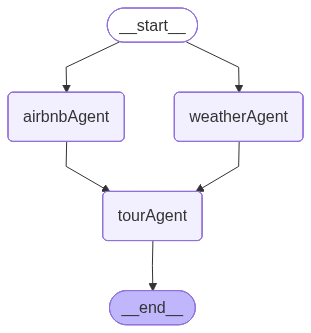

In [126]:
workflow = graph.compile()

Image(workflow.get_graph().draw_mermaid_png())

In [127]:
async for step in workflow.astream({"topic": "Find me the top 5 Airbnb in Goa for next 3 days within 8000 for 2 people ?"}):
    print(step)

display(Markdown(f"{step['tourAgent']['summary']}\n"))

Weather Agent..
Initializing connection...


WeatherForecast tool
Loading tools...
{'weatherAgent': {'knowledge': ['[Info from Weather Search]\n## Weather Report for Goa (Next 3 Days)\n\n**Current Conditions:** 25.8°C with Patchy rain nearby (Rain expected)\n\n**Forecast Summary:**\n- **2025-09-07:** Patchy rain nearby, 27.7°C / 25.5°C (Light rain expected)\n- **2025-09-08:** Moderate rain, 27.4°C / 25.1°C (Heavy rain expected)\n- **2025-09-09:** Patchy rain nearby, 27.5°C / 24.4°C (Light rain expected)\n\n**Tour Recommendation:**  \nBased on the weather forecast, it is NOT an ideal time to visit Goa due to continuous rain expected over the next 3 days. \n\n**Practical advice:**\n- **Clothing:** Pack waterproof jackets, umbrellas, and quick-dry clothing\n- **Precautions:** Be prepared for potential flooding in low-lying areas; avoid beach activities during heavy rain\n- **Activities:** Focus on indoor activities like visiting museums, churches, spice plantations with covered areas, casino visits, or enjoying Goan cuisine at cover

## 🎯 Search Summary  
- **Location:** Goa, India | **Dates:** 07 Sep → 10 Sep 2025 (3 nights)  
- **Guests:** 2A, 0C, 0I, 0P  
- **Room:** Entire place / Private room | **Stars:** 4.75 – 4.87 | **Amenities:** Wi-Fi, AC, Pool, Parking  
- **Results:** 5 Airbnbs ≤ ₹8 000 total  

---

## 🏨 Hotel Listings  

### RoomzAway Modern Studio Apt  
| Detail | Info |  
|--------|------|  
| ⭐ Rating | New listing (no reviews yet) |  
| 📍 Address | Central Goa (15.5259°N, 73.7677°E) |  
| 💰 Rate | ₹3 013 for 3 nights (₹1 004/night) |  
| 🏠 Rooms | Studio • 1 bath • Pool & parking |  
| 📏 Distance | 25 km to Mopa Airport • 10 km to Panjim |  
| 🔗 Booking | [Airbnb](https://www.airbnb.com/rooms/1410191289357716204) |  

### Xavier’s Guest House Deluxe Room  
| Detail | Info |  
|--------|------|  
| ⭐ Rating | 4.75/5 (353 reviews) • Superhost |  
| 📍 Address | Near Calangute, North Goa |  
| 💰 Rate | ₹3 204 for 3 nights (₹1 069/night) |  
| 🏠 Rooms | Deluxe double room • Shared terrace |  
| 📏 Distance | 35 km to Mopa Airport • 3 km to Calangute Beach |  
| 🔗 Booking | [Airbnb](https://www.airbnb.com/rooms/39852455) |  

### Studio Apt Calangute Field View  
| Detail | Info |  
|--------|------|  
| ⭐ Rating | 4.87/5 (45 reviews) • Guest Favourite |  
| 📍 Address | Calangute, North Goa |  
| 💰 Rate | ₹4 307 for 3 nights (₹1 436/night) |  
| 🏠 Rooms | 1-bed studio • Kitchenette • Balcony |  
| 📏 Distance | 35 km to Mopa Airport • 500 m to Calangute Beach |  
| 🔗 Booking | [Airbnb](https://www.airbnb.com/rooms/1294876725392746956) |  

### Rankk Stays – Deluxe Room  
| Detail | Info |  
|--------|------|  
| ⭐ Rating | New listing |  
| 📍 Address | North Goa (Arpora-Baga belt) |  
| 💰 Rate | ₹2 880 for 3 nights (₹960/night) |  
| 🏠 Rooms | Double room • Shared kitchen |  
| 📏 Distance | 32 km to Mopa Airport • 2 km to Baga Beach |  
| 🔗 Booking | [Airbnb](https://www.airbnb.com/rooms/1381750640795907439) |  

### Homely & Peaceful with Wi-Fi, AC  
| Detail | Info |  
|--------|------|  
| ⭐ Rating | 4.75/5 (208 reviews) |  
| 📍 Address | Siolim, North Goa |  
| 💰 Rate | ₹4 500 for 3 nights (₹1 500/night) |  
| 🏠 Rooms | 1-bed • AC • Wi-Fi • Work desk • Terrace |  
| 📏 Distance | 28 km to Mopa Airport • 4 km to Morjim Beach |  
| 🔗 Booking | [Airbnb](https://www.airbnb.com/rooms/51527106) |  

---

### 🏆 Final Picks  
- **Best Value:** Xavier’s Guest House – Superhost credibility, great reviews, still only ₹3 204 total.  
- **Luxury:** Calangute Field View Studio – highest rating (4.87), 500 m to beach, stylish interiors.  
- **Budget:** Rankk Stays – cheapest at ₹2 880, perfect for backpackers who just need a clean bed.  
- **Location:** Calangute Field View – walk to beach, restaurants & nightlife.  
- **Amenities:** RoomzAway Studio – only listing with pool & free parking, great for road-trippers.  

---

### 🌤️ Weather Summary  
- **Location:** Goa  
- **Duration:** 3 Days (07 Sep → 10 Sep 2025)  
- **Current:** 🌡️ 25.8 °C, Patchy rain nearby | Feels like 27 °C  
- **Humidity:** 83 % | **Wind:** 14 kph | **Pressure:** 1007 mb  

---

### 📅 3-Day Forecast  
| Date       | Condition        | 🌡️ Max Temp | 🌡️ Min Temp | 💧 Humidity | 💨 Max Wind |  
|------------|------------------|-------------|-------------|-------------|-------------|  
| 07 Sep     | Patchy rain nearby | 27.7 °C     | 25.5 °C     | 83 %        | 18 kph      |  
| 08 Sep     | Moderate rain    | 27.4 °C     | 25.1 °C     | 85 %        | 22 kph      |  
| 09 Sep     | Patchy rain nearby | 27.5 °C     | 24.4 °C     | 82 %        | 19 kph      |  

---

### 🧭 Travel & Stay Insights  
- **Clothing:** Quick-dry tees, shorts, light rain jacket, flip-flops & umbrella.  
- **Precautions:** Streets flood quickly; avoid bikes during heavy rain; keep electronics in dry-bags.  
- **Activities:** Skip beach shacks; opt for covered spice-plantation tours, Basilica & churches, casino boats, or café-hopping in Panjim/Assagao.  
- **Stay Match:** Choose properties with Wi-Fi & indoor seating (Xavier’s, Homely Peaceful) since you’ll be indoors 60 % of the time.  

---

### 🏡 Stay Match with Weather  
- **If Rainy/Cloudy:** Xavier’s Guest House & Homely Peaceful have cosy common areas, fast Wi-Fi, and covered balconies—perfect for sipping Kunjani coffee while it pours.  
- **If Sunny/Clear:** Calangute Field View balcony or RoomzAway pool deck let you soak up the brief sunshine between showers.  
- **If Mixed Weather:** Rankk Stays is cheap enough to extend your trip if flights get delayed by rain.  

### 🌟 Alternative Travel Note  
Because continuous rain is forecast, keep the last day flexible—book Airbnbs with free cancellation (Xavier’s & Homely offer this) and consider flying into Mopa (GOX) rather than Dabolim to avoid city water-logging.
